# Abalone dataset - linear regression

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt
import pandas as pd

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import KIND_COMPRESSION

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "abalone"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
path = "../dataset/abalone/abalone.csv"
data = pd.read_csv(path, sep=",", header = None)
data = data.rename(columns={ 0: "gender", 1: "Length", 2: "Diameter", 3: "Height", 8: "rings"})
data.head()

,gender,Length,Diameter,Height,4,5,6,7,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
data.groupby(data.gender).describe()

Length                                                       Diameter  \
         count      mean       std    min    25%    50%   75%    max    count   
gender                                                                          
F       1307.0  0.579093  0.086160  0.275  0.525  0.590  0.64  0.815   1307.0   
I       1342.0  0.427746  0.108858  0.075  0.360  0.435  0.51  0.725   1342.0   
M       1528.0  0.561391  0.102697  0.155  0.505  0.580  0.63  0.780   1528.0   

                  ...       7          rings                                 \
            mean  ...     75%    max   count       mean       std  min  25%   
gender            ...                                                         
F       0.454732  ...  0.3750  1.005  1307.0  11.129304  3.104256  5.0  9.0   
I       0.326494  ...  0.1785  0.655  1342.0   7.890462  2.511554  1.0  6.0   
M       0.439287  ...  0.3555  0.897  1528.0  10.705497  3.026349  3.0  9.0   

                          
         50%   75%   max  
gender                    
F       10.0  12.0  29.0  
I        8.0   9.0  21.0  
M       10.0  12.0  27.0  

[3 rows x 64 columns]

In [4]:
data.groupby(data.rings).describe()

Length                                                              \
       count      mean       std    min      25%     50%      75%    max   
rings                                                                      
1        1.0  0.075000       NaN  0.075  0.07500  0.0750  0.07500  0.075   
2        1.0  0.150000       NaN  0.150  0.15000  0.1500  0.15000  0.150   
3       15.0  0.176000  0.034754  0.110  0.15750  0.1800  0.20000  0.240   
4       57.0  0.221491  0.049839  0.130  0.18500  0.2250  0.25000  0.360   
5      115.0  0.285739  0.060659  0.155  0.25000  0.2800  0.32000  0.440   
6      259.0  0.369363  0.075215  0.170  0.32000  0.3700  0.41500  0.660   
7      391.0  0.422033  0.076018  0.205  0.37000  0.4250  0.47500  0.720   
8      568.0  0.498776  0.079221  0.255  0.45000  0.5000  0.55500  0.720   
9      689.0  0.546865  0.082891  0.280  0.50000  0.5600  0.60500  0.745   
10     634.0  0.574629  0.085484  0.290  0.53000  0.5900  0.63000  0.770   
11     487.0  0.599374  0.086864  0.310  0.55000  0.6200  0.65500  0.780   
12     267.0  0.589457  0.089453  0.350  0.52000  0.6000  0.65000  0.775   
13     203.0  0.578892  0.085463  0.320  0.51500  0.5800  0.64500  0.760   
14     126.0  0.580198  0.079891  0.385  0.52500  0.5800  0.63000  0.815   
15     103.0  0.575728  0.069007  0.420  0.52000  0.5850  0.62750  0.710   
16      67.0  0.587537  0.077172  0.395  0.53500  0.5900  0.64500  0.740   
17      58.0  0.601034  0.069628  0.490  0.54000  0.5925  0.64875  0.775   
18      42.0  0.596071  0.072981  0.425  0.55000  0.6050  0.64500  0.745   
19      32.0  0.595625  0.067904  0.450  0.54375  0.5900  0.64875  0.705   
20      26.0  0.603654  0.057438  0.500  0.56500  0.5975  0.64625  0.725   
21      14.0  0.618214  0.075182  0.490  0.56875  0.6350  0.67000  0.735   
22       6.0  0.595000  0.054314  0.520  0.55500  0.6050  0.63625  0.655   
23       9.0  0.587222  0.102869  0.450  0.51500  0.6100  0.62000  0.800   
24       2.0  0.695000  0.007071  0.690  0.69250  0.6950  0.69750  0.700   
25       1.0  0.645000       NaN  0.645  0.64500  0.6450  0.64500  0.645   
26       1.0  0.600000       NaN  0.600  0.60000  0.6000  0.60000  0.600   
27       2.0  0.607500  0.081317  0.550  0.57875  0.6075  0.63625  0.665   
29       1.0  0.700000       NaN  0.700  0.70000  0.7000  0.70000  0.700   

      Diameter            ...         6              7                      \
         count      mean  ...       75%     max  count      mean       std   
rings                     ...                                                
1          1.0  0.055000  ...  0.000500  0.0005    1.0  0.001500       NaN   
2          1.0  0.100000  ...  0.004000  0.0040    1.0  0.005000       NaN   
3         15.0  0.128667  ...  0.008750  0.0135   15.0  0.008933  0.004379   
4         57.0  0.161579  ...  0.017000  0.0350   57.0  0.018000  0.012419   
5        115.0  0.210696  ...  0.036250  0.0920  115.0  0.036770  0.020341   
6        259.0  0.278861  ...  0.073500  0.2940  259.0  0.078388  0.050190   
7        391.0  0.321535  ...  0.107250  0.3215  391.0  0.111648  0.056666   
8        568.0  0.384798  ...  0.185500  0.3855  568.0  0.178609  0.075504   
9        689.0  0.425218  ...  0.242000  0.5410  689.0  0.236509  0.091707   
10       634.0  0.449290  ...  0.282750  0.5250  634.0  0.282976  0.106811   
11       487.0  0.470595  ...  0.318000  0.5745  487.0  0.319866  0.116697   
12       267.0  0.462434  ...  0.303250  0.7600  267.0  0.321157  0.132397   
13       203.0  0.456453  ...  0.295500  0.5750  203.0  0.320828  0.116930   
14       126.0  0.458294  ...  0.295125  0.5410  126.0  0.329960  0.130170   
15       103.0  0.456262  ...  0.279500  0.4800  103.0  0.321650  0.114930   
16        67.0  0.468433  ...  0.307500  0.4725   67.0  0.377858  0.150074   
17        58.0  0.475345  ...  0.298000  0.4805   58.0  0.393414  0.161045   
18        42.0  0.471310  ...  0.309875  0.4370   42.0  0.386762  0.168441   
19        3

In [5]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [6]:
#Data processing
data["gender"] = data["gender"].replace(['M'], 1)
data["gender"] = data["gender"].replace(['I'], 0)
data["gender"] = data["gender"].replace(['F'], -1)

In [7]:
X_data = data.loc[:, data.columns != "rings"]
Y_data = data.loc[:, data.columns == "rings"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")
X_data.head()

There is 8 dimensions.


,gender,Length,Diameter,Height,4,5,6,7
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,-1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [8]:
print(Y_data.size)
Y_data.head()

4177


,rings
0,15
1,7
2,9
3,10
4,7


In [9]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [10]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)
X, Y = [], []

for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

Number of points by devices:  417
There is 10 devices.
torch.Size([417, 9])


In [11]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

   it    |   obj   
    4000 | 4.7268e-01
    8000 | 4.7267e-01
   12000 | 4.7267e-01
   16000 | 4.7267e-01


100%|██████████| 1/1 [01:30<00:00, 90.35s/it]

Gradient Descent: execution time=90.333 seconds
Final loss :  0.47267268002033236

CPU times: user 38.9 s, sys: 78.1 ms, total: 39 s
Wall time: 1min 30s


In [12]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True, nb_epoch=100, stochastic=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [03:05<12:20, 185.10s/it]

QSGD


 40%|████      | 2/5 [09:28<12:13, 244.62s/it]

Diana


 60%|██████    | 3/5 [12:54<07:46, 233.13s/it]

BiQSGD


 80%|████████  | 4/5 [16:30<03:47, 227.74s/it]

Artemis


100%|██████████| 5/5 [20:00<00:00, 240.20s/it]

CPU times: user 15min 11s, sys: 836 ms, total: 15min 12s
Wall time: 20min 1s


In [13]:
print("SGD model, the first value corresponds to the bias: ")
print(res.all_final_model[0])

SGD model, the first value corresponds to the bias: 
tensor([-2.8351e-04,  1.3799e-02,  1.1018e-02,  3.3377e-01,  1.7044e-01,
         4.7150e-01, -9.9433e-01, -1.1679e-01,  7.0937e-01],
       dtype=torch.float64)


Text(0, 0.5, 'true value')

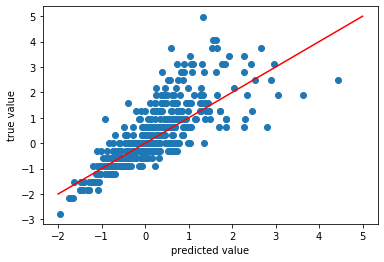

In [14]:
plt.scatter(X[0].mv(res.all_final_model[0]), Y[0])
plt.plot(np.linspace(-2, 5, 50), np.linspace(-2, 5, 50), color='r')
plt.xlabel("predicted value")
plt.ylabel("true value")

# With averaging

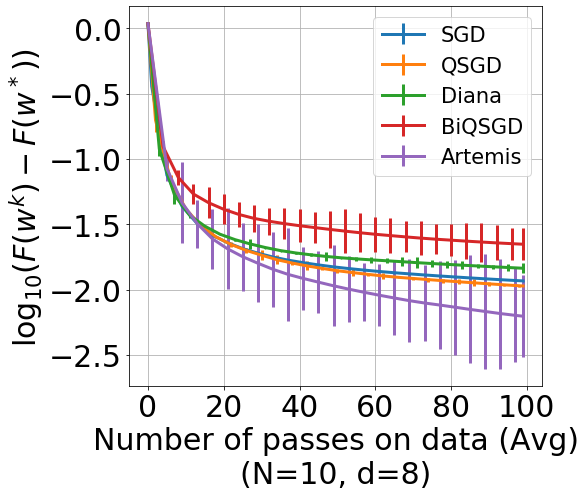

In [15]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

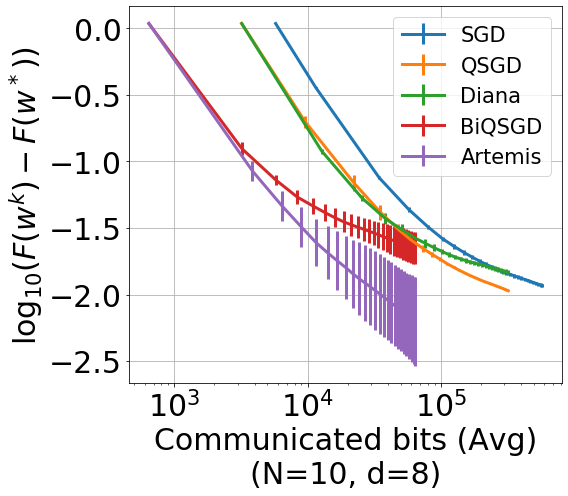

In [16]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Without averaging

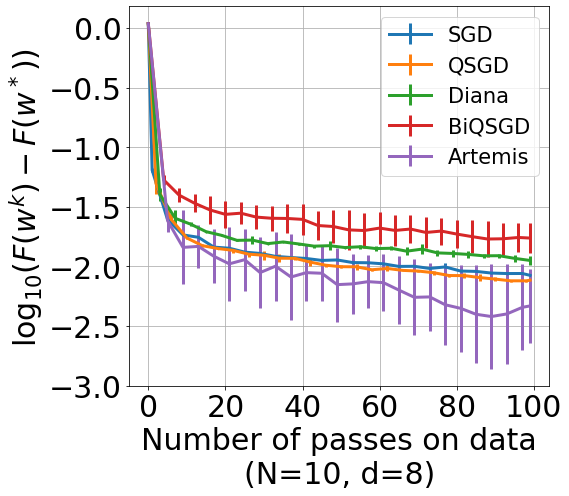

In [17]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

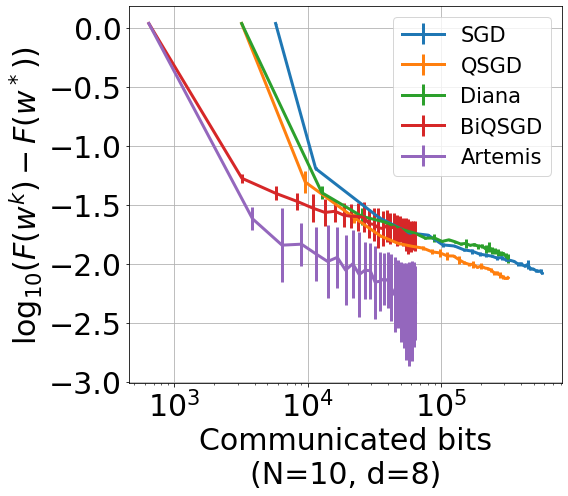

In [18]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

# Handling non-iid data

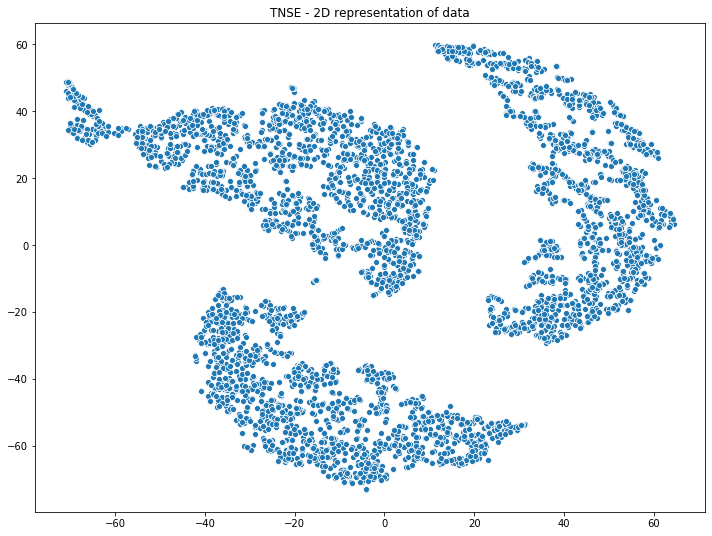

In [11]:
# Running TNSE to obtain a 2D representation of data
embedded_data = tnse(data)

There is 10 devices.
Number of points on device 0 : 508
Number of points on device 1 : 524
Number of points on device 2 : 537
Number of points on device 3 : 502
Number of points on device 4 : 503
Number of points on device 5 : 397
Number of points on device 6 : 389
Number of points on device 7 : 123
Number of points on device 8 : 399
Number of points on device 9 : 295


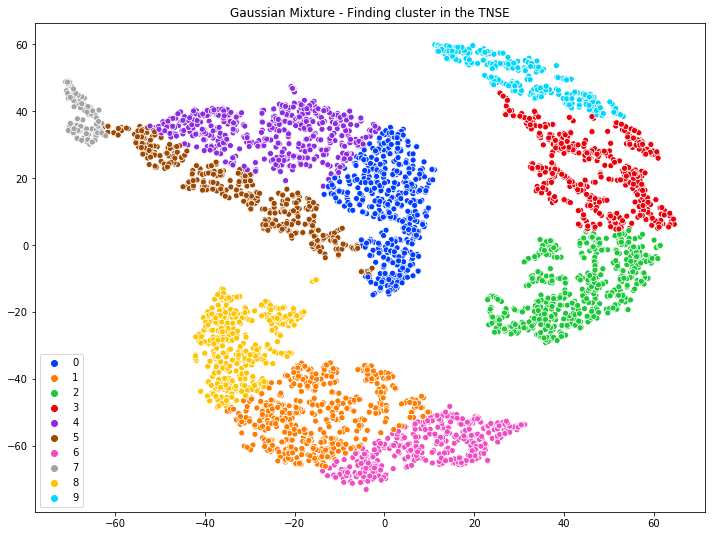

In [12]:
nb_cluster = 10
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "rings", nb_cluster, scale_Y=True)

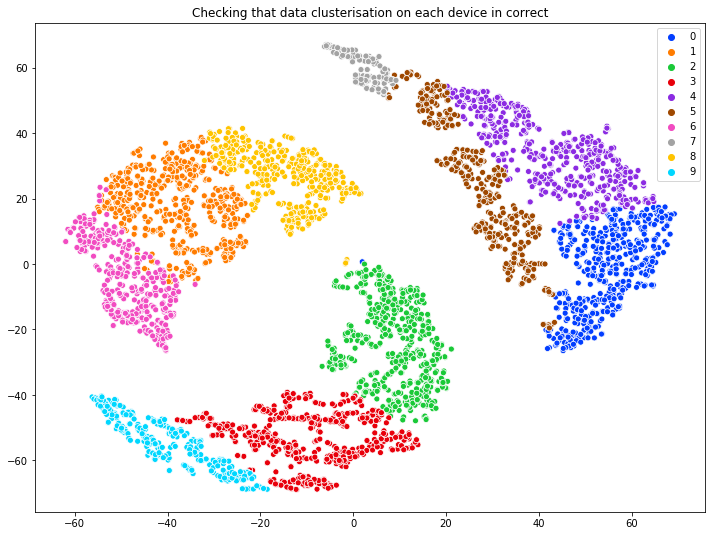

In [13]:
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [22]:
%%time
obj_min_by_N = {}

obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
obj_min_by_N_descent.run()
obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min_by_N, filename + "-noniid-obj_min")

   it    |   obj   
    4000 | 4.6064e-01
    8000 | 4.6060e-01
   12000 | 4.6060e-01
   16000 | 4.6060e-01
Gradient Descent: execution time=39.927 seconds
Final loss :  0.460603566467762

CPU times: user 1min 13s, sys: 3 s, total: 1min 16s
Wall time: 40 s


In [14]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = RMSEModel(), 
                                               use_averaging=True, stochastic=False, nb_epoch=400)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

QSGD


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

Diana


 60%|██████    | 3/5 [00:09<00:05,  2.84s/it]

BiQSGD


 80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

Artemis


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

CPU times: user 1min 3s, sys: 628 ms, total: 1min 4s
Wall time: 16 s


Text(0, 0.5, 'true value')

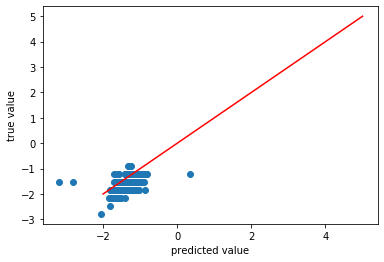

In [24]:
plt.scatter(X[6].mv(res.all_final_model[0]), Y[6])
plt.plot(np.linspace(-2, 5, 50), np.linspace(-2, 5, 50), color='r')
plt.xlabel("predicted value")
plt.ylabel("true value")

# With averaging

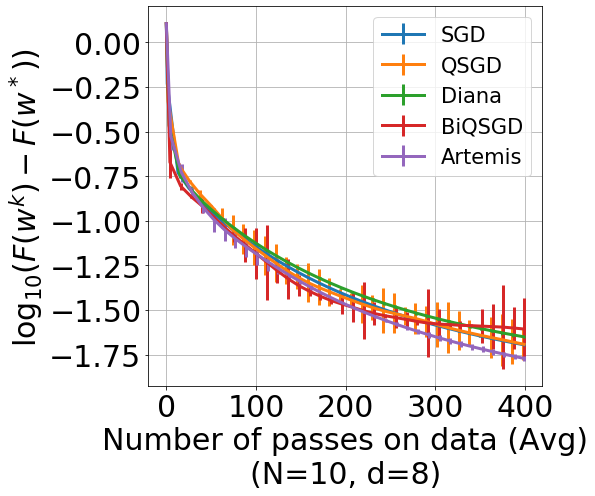

In [19]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

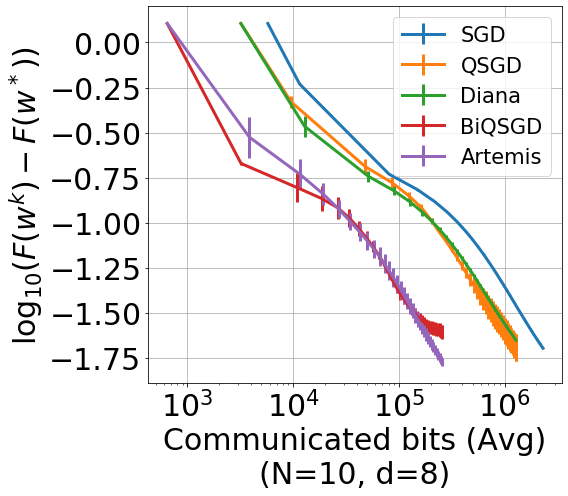

In [22]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Without averaging

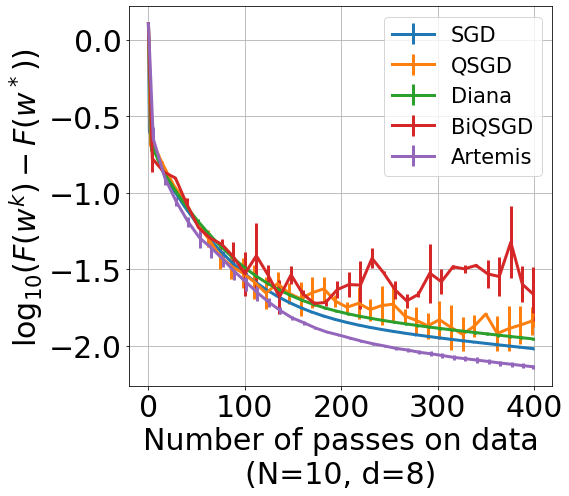

In [21]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

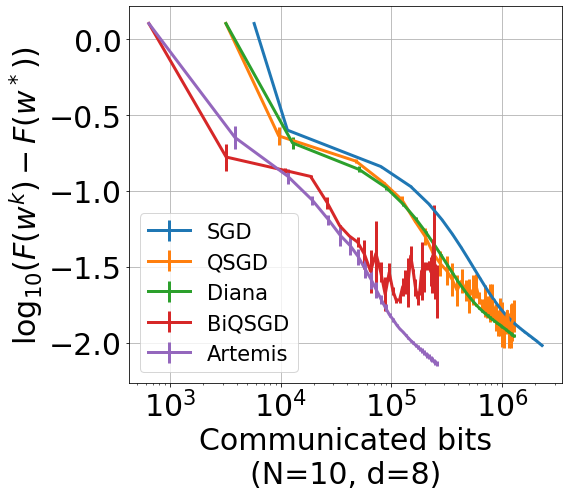

In [23]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 